In [11]:
from torch_geometric.datasets import *

import networkx as nx
from torch_geometric.data import Data
from torch_geometric.transforms import BaseTransform
from torch_geometric.utils import to_networkx
from networkit.nxadapter import nx2nk

import numpy as np
from networkit.centrality import Betweenness
from networkit.distance import APSP
from networkit.graph import Graph
from networkit.linkprediction import (
    JaccardIndex,
    CommonNeighborsIndex,
    PreferentialAttachmentIndex,
    AdamicAdarIndex,
    AdjustedRandIndex,
    AlgebraicDistanceIndex,
    KatzIndex
)
from networkit.sparsification import LocalDegreeScore
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SGConv
from torch_geometric.nn import Linear

In [12]:
# Triplets (Data, name, dataset_type)

datasets = [
    (Planetoid(root='/tmp/Cora', name='Cora'), 'Cora', 'Planetoid'),
    (Planetoid(root='/tmp/CiteSeer', name='CiteSeer'), 'CiteSeer', 'Planetoid'),
    (Planetoid(root='/tmp/PubMed', name='PubMed'), 'PubMed', 'Planetoid'),
    (Coauthor(root='/tmp/Physics', name='Physics'), 'Physics', 'Coauthor'),
    (Coauthor(root='/tmp/ComputerScience', name='CS'), 'CS', 'Coauthor'),
    #(Reddit(root='/tmp/Reddit'), 'Reddit', 'Reddit'),
    ]

try:
    datasets.append((TUDataset(root='./tmp/', name='ENZYMES', use_node_attr=True, use_edge_attr=True), 'Enzymes', 'Bioinformatics'))
except Exception as e:
    print("dupa")

try:
    datasets.append((TUDataset(root='./tmp/', name='PROTEINS', use_node_attr=True, use_edge_attr=True), 'Proteins', 'Bioinformatics'))
except Exception as e:
    print("dupa")

try:
    datasets.append((TUDataset(root='./tmp/', name='COLLAB', use_node_attr=True, use_edge_attr=True), 'Collab', 'Social Networks'))
except Exception as e:
    print("dupa")

# try:
#     datasets.append((TUDataset(root='./tmp/', name='AIDS', use_node_attr=True, use_edge_attr=True), 'AIDS', 'Small Molecules'))
# except Exception as e:
#     print("dupa")

# try:
#     datasets.append((TUDataset(root='./tmp/', name='benzene', use_node_attr=True, use_edge_attr=True), 'benzene', 'Small Molecules'))
# except Exception as e:
#     print("dupa")

# try:
#     datasets.append((TUDataset(root='./tmp/', name='aspirin', use_node_attr=True, use_edge_attr=True), 'aspirin', 'Small Molecules'))
# except Exception as e:
#     print("dupa")

dupa


dupa


dupa


In [13]:
datasets

[(Cora(), 'Cora', 'Planetoid'),
 (CiteSeer(), 'CiteSeer', 'Planetoid'),
 (PubMed(), 'PubMed', 'Planetoid'),
 (CoauthorPhysics(), 'Physics', 'Coauthor'),
 (CoauthorCS(), 'CS', 'Coauthor')]

In [18]:
class GCN_CUSTOM(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, dataset.num_node_features)
        self.conv2 = GCNConv(dataset.num_node_features, dataset.num_node_features)
        self.lin1 = Linear(dataset.num_node_features, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.lin1(x)

        return F.log_softmax(x, dim=1)

In [19]:
class SGC(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.conv1 = SGConv(dataset.num_node_features, dataset.num_node_features, K=2)
        self.conv2 = SGConv(dataset.num_node_features, dataset.num_node_features, K=2)
        self.lin1 = Linear(dataset.dataset.num_node_features, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.lin1(x)

        return F.log_softmax(x, dim=1)

In [20]:
from torch_geometric.nn.models import GCN, GraphSAGE, GIN, PNA, GAT

In [21]:
def calculate_shortest_paths(graph: Graph) -> np.array:
    # Networkit is faster than NetworkX for large graphs
    apsp = APSP(graph)
    apsp.run()
    path_lengths = apsp.getDistances(asarray=True)

    path_lengths = path_lengths.ravel()

    # filter out 0 length "paths" from node to itself
    path_lengths = path_lengths[np.nonzero(path_lengths)]

    # Networkit assigns extremely high values (~1e308) to mark infinite
    # distances for disconnected components, so we simply drop them
    path_lengths = path_lengths[path_lengths < 1e100]

    return path_lengths


def calculate_edge_betweenness(graph: Graph) -> np.ndarray:
    betweeness = Betweenness(graph, computeEdgeCentrality=True)
    betweeness.run()
    scores = betweeness.edgeScores()
    scores = np.array(scores, dtype=np.float32)
    return scores


In [22]:
class Calculate:
    def __init__(self, method, minmax=False, norm=False):
        self._method = method
        self._minmax = minmax
        self._norm = norm

    def run(self, graph: Graph) -> np.ndarray:
        index = self._method(graph)
        scores = [index.run(u, v) for u, v in graph.iterEdges()]
        scores = np.array(scores, dtype=np.float32)
        scores = scores[np.isfinite(scores)]
        if self._minmax:
            scores = (scores - np.min(scores)) / (np.max(scores) - np.min(scores) + np.finfo(np.float32).eps)
        if self._norm:
            scores = (scores - np.mean(scores)) / (np.std(scores) + np.finfo(np.float32).eps)
        return scores


class JaccardCalc(Calculate):
    def __init__(self, method=JaccardIndex, minmax=False, norm=True):
        super().__init__(method, minmax=minmax, norm=norm)


class CommonNeighborsCalc(Calculate):
    def __init__(self, method=CommonNeighborsIndex, minmax=False, norm=True):
        super().__init__(method, minmax=minmax, norm=norm)


class PreferentialAttachmentCalc(Calculate):
    def __init__(self, method=PreferentialAttachmentIndex, minmax=False, norm=True):
        super().__init__(method, minmax=minmax, norm=norm)


class AdamicAdarCalc(Calculate):
    def __init__(self, method=AdamicAdarIndex, minmax=False, norm=True):
        super().__init__(method, minmax=minmax, norm=norm)


class AdjustedRandCalc(Calculate):
    def __init__(self, method=AdjustedRandIndex, minmax=False, norm=True):
        super().__init__(method, minmax=minmax, norm=norm)


class AlgebraicDistanceCalc(Calculate):
    def __init__(self, method=AlgebraicDistanceIndex, minmax=False, norm=True):
        super().__init__(method, minmax=minmax, norm=norm)


class KatzCalc(Calculate):
    def __init__(self, method=KatzIndex, minmax=False, norm=True):
        super().__init__(method, minmax=minmax, norm=norm)

In [23]:
class BaseSparsing(BaseTransform):
    def __init__(self, power: float=None):
        super(BaseSparsing, self).__init__()
        self.power = power

    def __call__(self, data: Data) -> Data:
        raise NotImplementedError


class Random(BaseSparsing):
    def __init__(self, power: float=None):
        super(Random, self).__init__(power=power)

    def __call__(self, data: Data) -> Data:
        if self.power is not None:
            edge_index = data.edge_index
            percentage_num_nodes = int(edge_index.size(1) * self.power)
            data.edge_index = edge_index[:, :-percentage_num_nodes]
        return data

    def f(self, data: Data) -> Data:
        return self.__call__(data)

Value at 90% threshold: 1.28


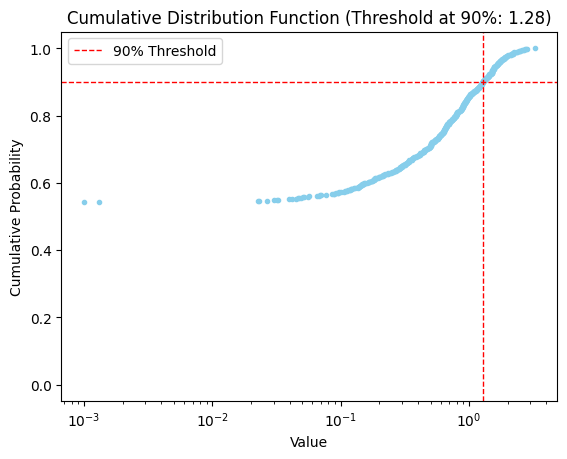

In [24]:
import matplotlib.pyplot as plt

def show_histogram(data):
    plt.hist(data, bins=30, density=False, alpha=0.7, color='skyblue')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.xscale('log')
    plt.yscale('log')

    plt.title('Histogram of Values')
    plt.show()

def show_histogram2(data, percentile_threshold=95):
    """
    Plots a histogram of the data and prints the x-value corresponding to the
    specified percentile threshold.

    Args:
        data (numpy.ndarray): The data to plot.
        percentile_threshold (float): The percentile threshold to calculate (default is 95).
    """

    # Calculate the value at the specified percentile
    threshold_value = np.percentile(data, percentile_threshold)

    # Plot the histogram
    plt.hist(data, bins=30, density=False, alpha=0.7, color='skyblue')
    plt.xlabel('Value')
    plt.xscale('log')
    plt.yscale('log')

    plt.ylabel('Frequency')
    plt.title(f'Histogram of Values (Threshold at {percentile_threshold}%: {threshold_value:.2f})')

    # Add a vertical line at the threshold
    plt.axvline(x=threshold_value, color='red', linestyle='dashed', linewidth=1, label=f'{percentile_threshold}% Threshold')

    # Add legend
    plt.legend()

    # Print the threshold value
    print(f"Value at {percentile_threshold}% threshold: {threshold_value:.2f}")

    plt.show()

import numpy as np
import matplotlib.pyplot as plt

def show_cdf(data, percentile_threshold=95, dataset: str=None, algo: str=None):
    """
    Plots the cumulative distribution function (CDF) of the data and
    prints the x-value corresponding to the specified percentile threshold.

    Args:
        data (numpy.ndarray): The data to plot.
        percentile_threshold (float): The percentile threshold to calculate (default is 95).
    """

    # Sort the data
    sorted_data = np.sort(data)

    # Calculate the CDF values (cumulative probabilities)
    cdf_values = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

    # Calculate the value at the specified percentile
    threshold_value = np.percentile(data, percentile_threshold)

    # Plot the CDF
    plt.plot(sorted_data, cdf_values, marker='.', linestyle='none', color='skyblue')
    plt.xlabel('Value')
    plt.xscale('log')

    plt.ylabel('Cumulative Probability')
    plt.title(f'CDF of {algo} on {dataset} dataset (Threshold at {percentile_threshold}%: {threshold_value:.2f})')

    # Add a horizontal line at the threshold and a vertical line at the corresponding x-value
    plt.axhline(y=percentile_threshold / 100, color='red', linestyle='dashed', linewidth=1, label=f'{percentile_threshold}% Threshold')
    plt.axvline(x=threshold_value, color='red', linestyle='dashed', linewidth=1)

    # Add legend
    plt.legend()

    # Print the threshold value
    print(f"Value at {percentile_threshold}% threshold: {threshold_value:.2f}")

    plt.show()

# Example usage
data = np.random.normal(0, 1, 1000)  # Generate some data
show_cdf(data, 90)  # Change the percentile threshold as needed

    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class IndexMain(BaseSparsing):
    def __init__(self, power: int=None, calc=None, calc_name=None):
        super(IndexMain, self).__init__(power=power)
        self._calc = calc
        self._calc_name = calc_name

    def _main_calc(self, G):
        return self._calc.run(G)

    def __call__(self, data: Data, data_name: str) -> Data:
        if self.power is not None:
            edge_index = data.edge_index
            mask = edge_index[0] < edge_index[1]
            edge_index = edge_index[:, mask]
            G = to_networkx(data, to_undirected=True)
            G = nx2nk(G)
            edge_weights = self._main_calc(G)
            show_cdf(edge_weights, data_name, self._calc_name)
            edge_index = edge_index[:, edge_weights >= self.power]
            edge_index = torch.cat([edge_index, torch.flip(edge_index, dims=[0])], dim=1)
            data.edge_index = edge_index
        return data

    def f(self, data: Data) -> Data:
        return self.__call__(data)


class Jaccard(IndexMain):
    def __init__(self, power: int=None, calc=JaccardCalc()):
        super(Jaccard, self).__init__(power=power, calc=calc, calc_name='Jaccard')


class CommonNeighbor(IndexMain):
    def __init__(self, power: int=None, calc=CommonNeighborsCalc()):
        super(CommonNeighbor, self).__init__(power=power, calc=calc, calc_name='CommonNeighbor')


class PreferentialAttachment(IndexMain):
    def __init__(self, power: int=None, calc=PreferentialAttachmentCalc()):
        super(PreferentialAttachment, self).__init__(power=power, calc=calc, calc_name='PreferentialAttachment')


class AdamicAdar(IndexMain):
    def __init__(self, power: int=None, calc=AdamicAdarCalc()):
        super(AdamicAdar, self).__init__(power=power, calc=calc, calc_name='AdamicAdar')


class AdjustedRand(IndexMain):
    def __init__(self, power: int=None, calc=AdjustedRandCalc()):
        super(AdjustedRand, self).__init__(power=power, calc=calc, calc_name='AdjustedRand')


class AlgebraicDistance(IndexMain):
    def __init__(self, power: int=None, calc=AlgebraicDistanceCalc()):
        super(AlgebraicDistance, self).__init__(power=power, calc=calc, calc_name='AlgebraicDistance')


class Katz(IndexMain):
    def __init__(self, power: int=None, calc=KatzCalc()):
        super(Katz, self).__init__(power=power, calc=calc, calc_name='Katz')


In [25]:
def run_exp(dataset, sparsing_alg=None, model_type=GCN):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model_type(dataset).to(device)
    data = dataset[0].to(device)
    if sparsing_alg is not None:
        data = sparsing_alg.f(data)
    return 1.0
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc

Using device: cuda


C:\Users\piotr\AppData\Local\Temp\ipykernel_45760\942181117.py:12: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1807.)
  print(f'{model_name} on {dataset} with {string} sparsing: {torch.tensor(acc).mean():.2%} ± {torch.tensor(acc).std():.2%}')


GCN_CUSTOM on CiteSeer() with no sparsing: 100.00% ± nan%
Value at 95% threshold: 1.15


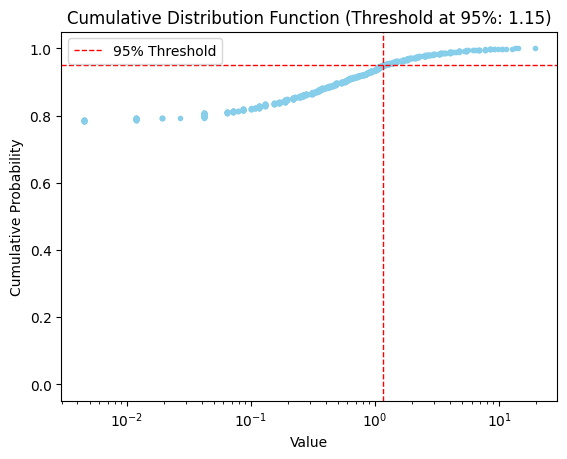

GCN_CUSTOM on CiteSeer() with PA sparsing: 100.00% ± nan%
Value at 95% threshold: 2.33


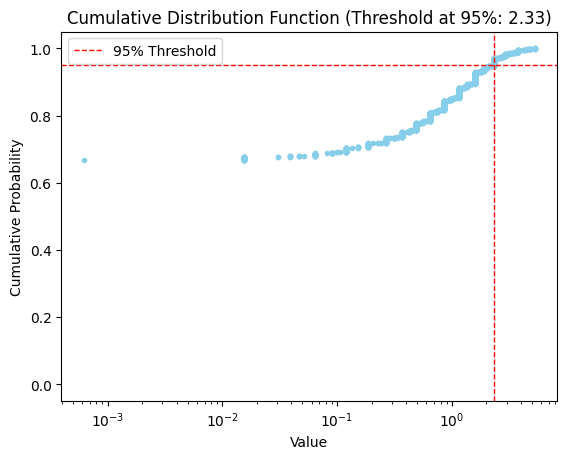

GCN_CUSTOM on CiteSeer() with Jaccard sparsing: 100.00% ± nan%
GCN_CUSTOM on PubMed() with no sparsing: 100.00% ± nan%
Value at 95% threshold: 1.54


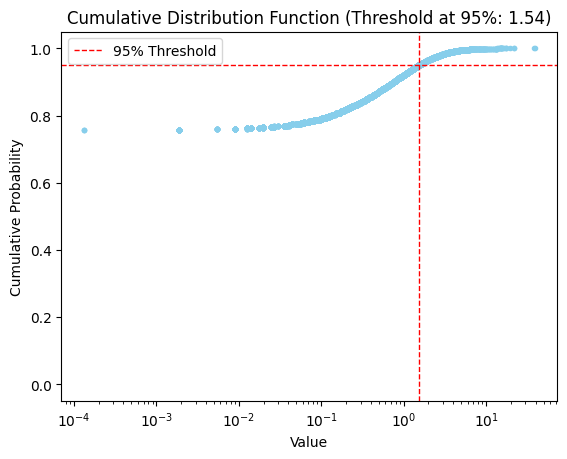

GCN_CUSTOM on PubMed() with PA sparsing: 100.00% ± nan%
Value at 95% threshold: 1.98


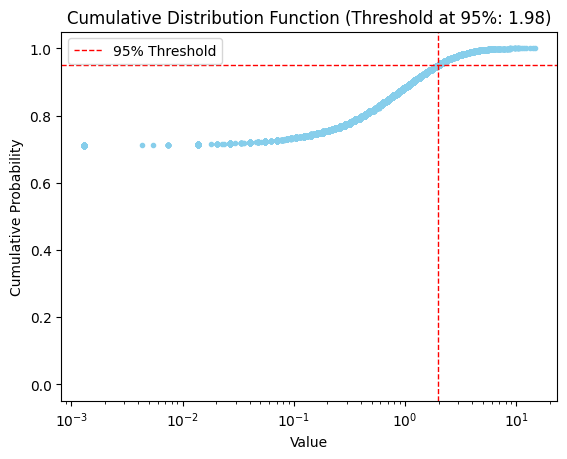

GCN_CUSTOM on PubMed() with Jaccard sparsing: 100.00% ± nan%
GCN_CUSTOM on CoauthorPhysics() with no sparsing: 100.00% ± nan%
Value at 95% threshold: 1.44


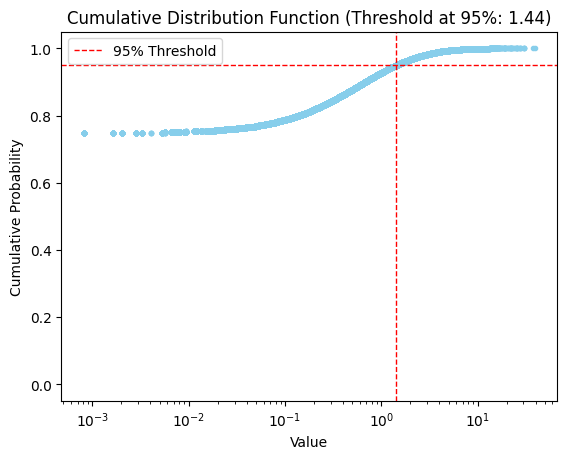

GCN_CUSTOM on CoauthorPhysics() with PA sparsing: 100.00% ± nan%
Value at 95% threshold: 2.01


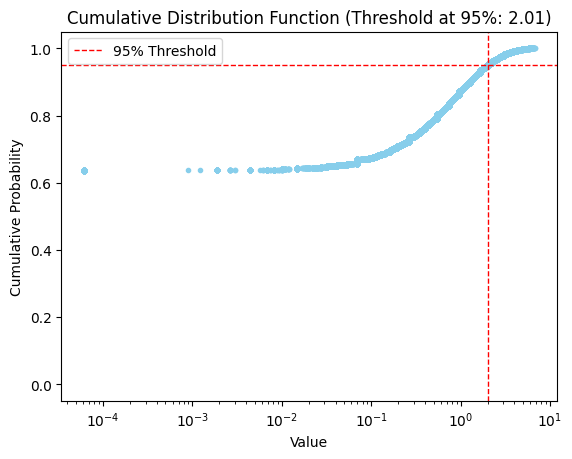

GCN_CUSTOM on CoauthorPhysics() with Jaccard sparsing: 100.00% ± nan%
GCN_CUSTOM on CoauthorCS() with no sparsing: 100.00% ± nan%
Value at 95% threshold: 1.67


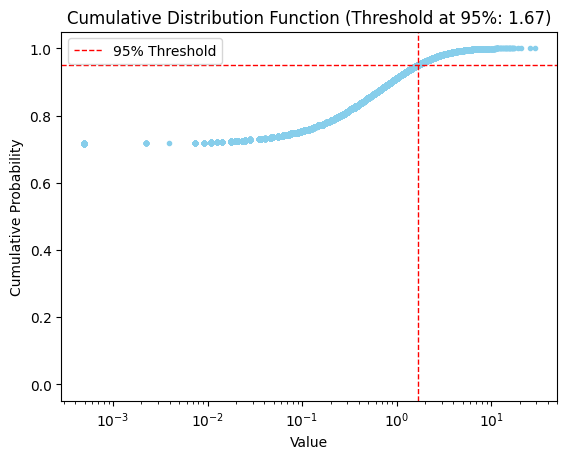

GCN_CUSTOM on CoauthorCS() with PA sparsing: 100.00% ± nan%
Value at 95% threshold: 2.02


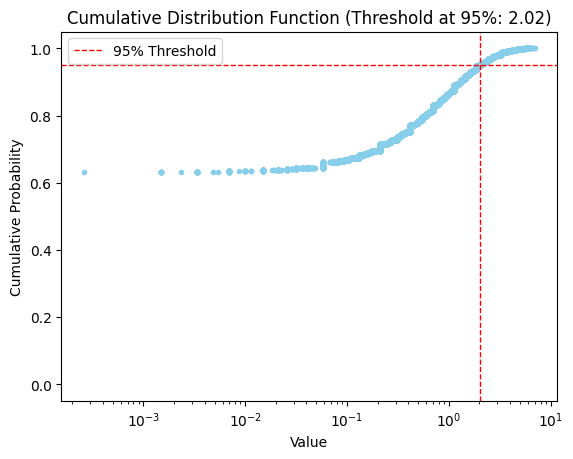

GCN_CUSTOM on CoauthorCS() with Jaccard sparsing: 100.00% ± nan%


In [26]:
from tqdm import tqdm

device = torch.device('cuda')
print(f'Using device: {device}')

def call_exp(sparsing_alg, string):
  acc = [run_exp(
      dataset,
      sparsing_alg=sparsing_alg,
      model_type=model_type
      ) for _ in range(run_num)]
  print(f'{model_name} on {dataset} with {string} sparsing: {torch.tensor(acc).mean():.2%} ± {torch.tensor(acc).std():.2%}')

custom_models = [GCN, SGC]
custom_model_names = ["GCN_CUSTOM", "SGC"]
pretrained_models = [GCN, GraphSAGE, GIN, PNA, GAT] # morgul
pretrained_models = ["GCN", "GraphSAGE", "GIN", "PNA", "GAT"]

for dataset in datasets:
  for model_type, model_name in zip([GCN_CUSTOM], ["GCN_CUSTOM"]):
    run_num = 1 #TODO
    RANDOM_POWER = 0.1
    PA_POWER = -2
    JACCARD_POWER = -2
    for sparsing_alg, string in zip([None, PreferentialAttachment(PA_POWER), Jaccard(JACCARD_POWER)], ["no", "PA", "Jaccard"]):
      call_exp(sparsing_alg, string)